In [63]:
import os, time
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import warnings

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.feature_selection import f_classif, mutual_info_classif, RFE, RFECV, SelectKBest, SequentialFeatureSelector
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, FeatureAgglomeration, SpectralClustering

from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, classification_report, ConfusionMatrixDisplay, silhouette_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold, train_test_split, ParameterGrid, ValidationCurveDisplay, StratifiedGroupKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV, Perceptron
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.model_selection import train_test_split

from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from keras.layers import Dense, Dropout, Normalization, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scikeras.wrappers import KerasClassifier

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

from sklearn.model_selection import cross_val_score, cross_val_predict
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedGroupKFold, GroupShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer

In [64]:
path_to_training_data = r"training_data_dates_over_years.gpkg"
training_data_layer_name = "stands_Training_data"

training_data = gpd.read_file(path_to_training_data, layer=training_data_layer_name)
training_data.head()

,fid_1,ID,XCOORD,YCOORD,HEIGHT,SPECIES,Shape_Length,Shape_Area,INV_UNIT,PAR_UNIT,...,NDBI_08-01_MEAN,NDBI_08-11_MEAN,NDBI_08-21_MEAN,NDBI_09-01_MEAN,NDBI_09-11_MEAN,NDBI_09-21_MEAN,NDBI_10-01_MEAN,NDBI_10-11_MEAN,NDBI_10-21_MEAN,geometry
0,2322012.0,67330,604767.870,6913829.000,20.592600,2.0,16.0,9.875,22454000,NaN,...,-0.476858,-0.469180,-0.482851,-0.497415,-0.488341,-0.477839,-0.472446,-0.426320,-0.418108,"MULTIPOLYGON (((604766.37 6913830.75, 604766.8..."
1,2322222.0,8147,604771.495,6913828.125,25.119101,2.0,19.5,14.375,22454001,NaN,...,-0.476858,-0.469180,-0.482851,-0.497415,-0.488341,-0.477839,-0.472446,-0.426320,-0.418108,"MULTIPOLYGON (((604771.37 6913830.5, 604771.87..."
2,2322523.0,8184,604776.995,6913824.375,25.944401,2.0,29.0,25.000,22454002,NaN,...,-0.464200,-0.455254,-0.471066,-0.486093,-0.484010,-0.482644,-0.478856,-0.436272,-0.433940,"MULTIPOLYGON (((604775.62 6913827.75, 604776.1..."
3,2322537.0,67317,604767.870,6913823.625,20.515301,2.0,17.0,10.375,22454003,NaN,...,-0.476858,-0.469180,-0.482851,-0.497415,-0.488341,-0.477839,-0.472446,-0.426320,-0.418108,"MULTIPOLYGON (((604769.12 6913825.75, 604769.3..."
4,2322718.0,8200,604771.870,6913822.875,25.156799,2.0,26.5,21.875,22454004,NaN,...,-0.477387,-0.463910,-0.473634,-0.486976,-0.487947,-0.489706,-0.464757,-0.411976,-0.405982,"MULTIPOLYGON (((604772.62 6913826.25, 604772.8..."


In [65]:
lidar_ch1_features = training_data.filter(regex=r"^L_Ch1_.*")
lidar_ch2_features = training_data.filter(regex=r"^L_Ch2_.*")
lidar_ch3_features = training_data.filter(regex=r"^L_Ch3_.*")

lidar_features = pd.concat([lidar_ch1_features, lidar_ch2_features, lidar_ch3_features], axis=1)
y = training_data["SPECIES"]

In [47]:
print(np.isnan(lidar_features).sum())

L_Ch1_VEG_Z95       7
L_Ch1_VEG_Z90       7
L_Ch1_VEG_Z85       7
L_Ch1_VEG_Z80       7
L_Ch1_VEG13_Z95    32
                   ..
L_Ch3_LI5_IA3       7
L_Ch3_D_RF          2
L_Ch3_D_RL          2
L_Ch3_D_RI          2
L_Ch3_D_RO          2
Length: 309, dtype: int64


In [66]:
X_lidar = pd.concat([lidar_features, training_data["HEIGHT"]], axis=1)

In [67]:
X_train_lidar, X_test_lidar, y_train_lidar, y_test_lidar = train_test_split(X_lidar, y, test_size=0.2, random_state=1, stratify=y)

In [ ]:
def train_model(model, X_train, X_test, y_train, y_test):
    model_copy = deepcopy(model)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="UserWarning: Skipping features without any observed values")
        if type(model_copy) is GridSearchCV:
            model_copy.fit(X_train, y_train)
          
            #print(f"Best CV accuracy: {model_copy.best_score_:.3f} ± {model_copy.cv_results_['std_test_score'][model_copy.best_index_]:.3f}")
            
            mean_f1 = np.mean(model_copy.cv_results_["mean_test_f1_macro"])
            std_f1 = np.std(model_copy.cv_results_["std_test_f1_macro"])
            mean_ba = np.mean(model_copy.cv_results_["mean_test_balanced_accuracy"])
            std_ba = np.std(model_copy.cv_results_["std_test_balanced_accuracy"])
            mean_oa = np.mean(model_copy.cv_results_["mean_test_accuracy"])
            std_oa = np.std(model_copy.cv_results_["std_test_accuracy"])
            print(f"Mean CV accuracy: {mean_oa:.3f}, ± {std_oa:.3f}")
            print(f"Mean CV BA: {mean_ba:.3f}, ± {std_ba:.3f}")
            print(f"Mean CV f1: {mean_f1:.3f}, ± {std_f1:.3f}")
           
            std_score_dof = np.std(model_copy.cv_results_["mean_test_accuracy"], ddof=1)
            print(f"95% CI: ({1.96 * std_score_dof / np.sqrt(len(model_copy.cv_results_['mean_test_accuracy'])):.3f})")

            print("Best params:", model_copy.best_params_)
            best_model = model_copy.best_estimator_  

            y_pred = best_model.predict(X_test)
            print(f"Test set accuracy: {best_model.score(X_test, y_test):.3f}")  
        else:
            model_copy.fit(X_train, y_train)
            y_pred = model_copy.predict(X_test) 
        
    print("Classification report\n", classification_report(y_test, y_pred))
    print("Balanced accuracy score:", balanced_accuracy_score(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
    return model_copy

In [69]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [70]:
#get cv results
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score, average='macro'),
           'recall' : make_scorer(recall_score, average='macro'),
           'f1_macro' : make_scorer(f1_score, average='macro'),
           'balanced_accuracy': make_scorer(balanced_accuracy_score)}

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 1/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.786) balanced_accuracy: (train=0.999, test=0.594) f1_macro: (train=0.999, test=0.609) precision: (train=1.000, test=0.675) recall: (train=0.999, test=0.594) total time=   1.1s
[CV 2/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 2/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.758) balanced_accuracy: (train=1.000, test=0.562) f1_macro: (train=1.000, test=0.584) precision: (train=1.000, test=0.638) recall: (train=1.000, test=0.562) total time=   0.8s
[CV 3/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 3/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=0.999, test=0.789) balanced_accuracy: (train=0.998, test=0.591) f1_macro: (train=0.

C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5; 4/6] END clf__max_depth=5, clf__n_estimators=100; accuracy: (train=0.795, test=0.775) balanced_accuracy: (train=0.556, test=0.512) f1_macro: (train=0.590, test=0.510) precision: (train=0.889, test=0.537) recall: (train=0.556, test=0.512) total time=   0.8s
[CV 2/5; 4/6] START clf__max_depth=5, clf__n_estimators=100.....................
[CV 2/5; 4/6] END clf__max_depth=5, clf__n_estimators=100; accuracy: (train=0.815, test=0.759) balanced_accuracy: (train=0.598, test=0.506) f1_macro: (train=0.642, test=0.517) precision: (train=0.878, test=0.638) recall: (train=0.598, test=0.506) total time=   1.0s
[CV 3/5; 4/6] START clf__max_depth=5, clf__n_estimators=100.....................
[CV 3/5; 4/6] END clf__max_depth=5, clf__n_estimators=100; accuracy: (train=0.808, test=0.772) balanced_accuracy: (train=0.566, test=0.518) f1_macro: (train=0.595, test=0.520) precision: (train=0.900, test=0.695) recall: (train=0.566, test=0.518) total time=   0.9s
[CV 4/5; 4/6] START clf__max_depth=5, cl

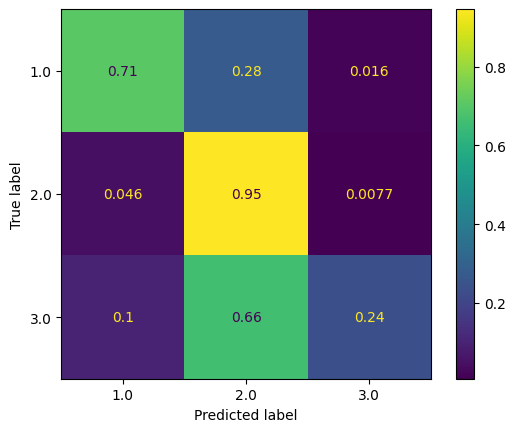

In [71]:
try:
    rf_cv = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="mean")),
        ("scaler", RobustScaler()),
        ("pca", PCA(n_components=12)),
        ("clf", RandomForestClassifier(random_state=1))
    ])
    
    params = {
        "clf__n_estimators": [50, 100], 
        "clf__max_depth": [None, 5, 10],
    }
    
    gs = GridSearchCV(
        rf_cv,
        params,
        n_jobs=1,
        cv=cv,
        scoring=scoring,
        verbose=10, 
        refit="balanced_accuracy", 
        return_train_score=True
    )
    
    rf_cv = train_model(gs, X_train_lidar, X_test_lidar, y_train_lidar, y_test_lidar)
    #plot_cv_results(cv_results=rf_cv.cv_results_, param_1="n_trees")
except Exception as e:
    print("Something went wrong :(\n", e)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 1/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.802) balanced_accuracy: (train=0.999, test=0.605) f1_macro: (train=0.999, test=0.637) precision: (train=1.000, test=0.739) recall: (train=0.999, test=0.605) total time=   1.0s
[CV 2/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 2/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.764) balanced_accuracy: (train=1.000, test=0.567) f1_macro: (train=1.000, test=0.595) precision: (train=1.000, test=0.672) recall: (train=1.000, test=0.567) total time=   1.1s
[CV 3/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 3/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.801) balanced_accuracy: (train=0.999, test=0.589) f1_macro: (train=1.

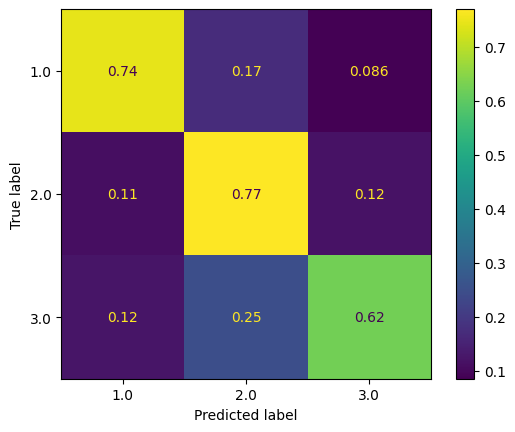

In [79]:
try:
    rf_cv = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="mean")),
        ("scaler", RobustScaler()),
        ("pca", PCA(n_components=12)),
        ("clf", RandomForestClassifier(random_state=1, class_weight="balanced"))
    ])
    
    params = {
        "clf__n_estimators": [50, 100], 
        "clf__max_depth": [None, 5, 10],
    }
    
    gs = GridSearchCV(
        rf_cv,
        params,
        n_jobs=1,
        cv=cv,
        scoring=scoring,
        verbose=10, 
        refit="balanced_accuracy", 
        return_train_score=True
    )
    
    rf_cv = train_model(gs, X_train_lidar, X_test_lidar, y_train_lidar, y_test_lidar)
    #plot_cv_results(cv_results=rf_cv.cv_results_, param_1="n_trees")
except Exception as e:
    print("Something went wrong :(\n", e)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 1/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.781) balanced_accuracy: (train=1.000, test=0.680) f1_macro: (train=1.000, test=0.680) precision: (train=1.000, test=0.688) recall: (train=1.000, test=0.680) total time=   1.2s
[CV 2/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 2/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.758) balanced_accuracy: (train=1.000, test=0.646) f1_macro: (train=1.000, test=0.644) precision: (train=1.000, test=0.658) recall: (train=1.000, test=0.646) total time=   1.2s
[CV 3/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 3/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.761) balanced_accuracy: (train=0.999, test=0.632) f1_macro: (train=1.

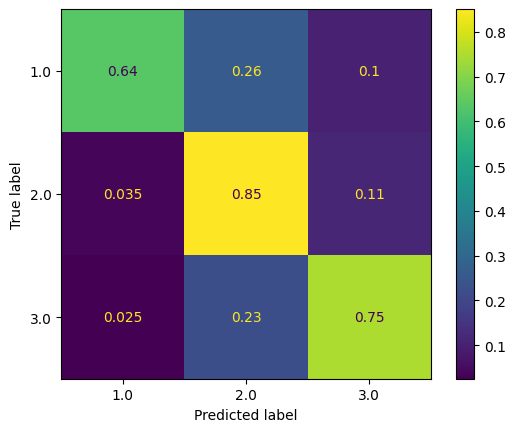

In [72]:
try:
    rf_cv = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="mean")),
        ("scaler", RobustScaler()),
        ("pca", PCA(n_components=12)),
        ("smote", SMOTE(sampling_strategy='minority', random_state=1)),
        ("clf", RandomForestClassifier(random_state=1))
    ])
    
    params = {
        "clf__n_estimators": [50, 100], 
        "clf__max_depth": [None, 5, 10],
    }
    
    gs = GridSearchCV(
        rf_cv,
        params,
        n_jobs=1,
        cv=cv,
        scoring=scoring,
        verbose=10, 
        refit="balanced_accuracy", 
        return_train_score=True
    )
    
    rf_cv = train_model(gs, X_train_lidar, X_test_lidar, y_train_lidar, y_test_lidar)
    #plot_cv_results(cv_results=rf_cv.cv_results_, param_1="n_trees")
except Exception as e:
    print("Something went wrong :(\n", e)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 1/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.785) balanced_accuracy: (train=1.000, test=0.680) f1_macro: (train=1.000, test=0.678) precision: (train=1.000, test=0.687) recall: (train=1.000, test=0.680) total time=   1.1s
[CV 2/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 2/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.743) balanced_accuracy: (train=1.000, test=0.615) f1_macro: (train=1.000, test=0.621) precision: (train=1.000, test=0.639) recall: (train=1.000, test=0.615) total time=   1.0s
[CV 3/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 3/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.767) balanced_accuracy: (train=0.999, test=0.656) f1_macro: (train=1.

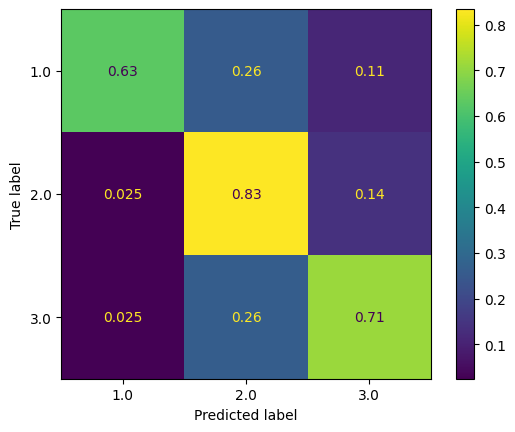

In [73]:
try:
    rf_cv = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="mean")),
        ("scaler", RobustScaler()),
        ("pca", PCA(n_components=12)),
        ("adasyn", ADASYN(sampling_strategy='minority', random_state=1)),
        ("clf", RandomForestClassifier(random_state=1))
    ])
    
    params = {
        "clf__n_estimators": [50, 100], 
        "clf__max_depth": [None, 5, 10],
    }
    
    gs = GridSearchCV(
        rf_cv,
        params,
        n_jobs=1,
        cv=cv,
        scoring=scoring,
        verbose=10, 
        refit="balanced_accuracy", 
        return_train_score=True
    )
    
    rf_cv = train_model(gs, X_train_lidar, X_test_lidar, y_train_lidar, y_test_lidar)
    #plot_cv_results(cv_results=rf_cv.cv_results_, param_1="n_trees")
except Exception as e:
    print("Something went wrong :(\n", e)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 1/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.777) balanced_accuracy: (train=0.999, test=0.666) f1_macro: (train=0.999, test=0.668) precision: (train=1.000, test=0.677) recall: (train=0.999, test=0.666) total time=   1.4s
[CV 2/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 2/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=1.000, test=0.758) balanced_accuracy: (train=1.000, test=0.631) f1_macro: (train=1.000, test=0.640) precision: (train=1.000, test=0.659) recall: (train=1.000, test=0.631) total time=   1.0s
[CV 3/5; 1/6] START clf__max_depth=None, clf__n_estimators=50...................
[CV 3/5; 1/6] END clf__max_depth=None, clf__n_estimators=50; accuracy: (train=0.999, test=0.788) balanced_accuracy: (train=0.999, test=0.663) f1_macro: (train=0.

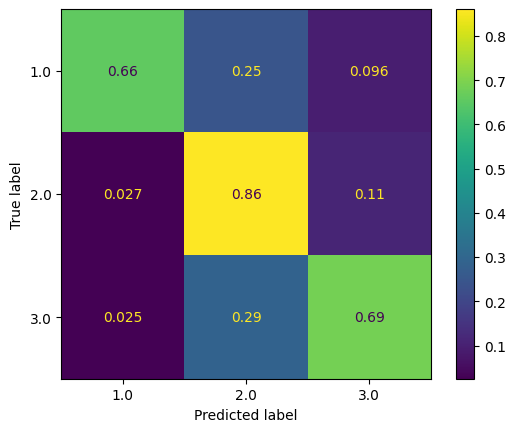

In [74]:
try:
    rf_cv = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="mean")),
        ("scaler", RobustScaler()),
        ("pca", PCA(n_components=12)),
        ("bsmote", BorderlineSMOTE(sampling_strategy='minority', random_state=1)),
        ("clf", RandomForestClassifier(random_state=1))
    ])
    
    params = {
        "clf__n_estimators": [50, 100], 
        "clf__max_depth": [None, 5, 10],
    }
    
    gs = GridSearchCV(
        rf_cv,
        params,
        n_jobs=1,
        cv=cv,
        scoring=scoring,
        verbose=10, 
        refit="balanced_accuracy", 
        return_train_score=True
    )
    
    rf_cv = train_model(gs, X_train_lidar, X_test_lidar, y_train_lidar, y_test_lidar)
    #plot_cv_results(cv_results=rf_cv.cv_results_, param_1="n_trees")
except Exception as e:
    print("Something went wrong :(\n", e)

In [75]:
def train_mlp(pipeline, X_train, X_test, y_train, y_test):
    param_grid = {
    "clf__model__hidden_layers": [(64,32,16), (128,64,32)],
    "clf__model__learning_rate": [1e-4],
    "clf__epochs":        [50,100],
    "clf__batch_size":    [32, 64],
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    gscv = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=1,
        verbose=2,
        refit="balanced_accuracy",
        return_train_score=True
    )
    gscv.fit(X_train, y_train)

    std = gscv.cv_results_["std_test_accuracy"][gscv.best_index_]
    print(f"Best CV BA: {gscv.best_score_:.3f}, ± {std:.3f}")
    print("train score", gscv.cv_results_['mean_train_accuracy'], "vs. cv test score", gscv.cv_results_['mean_test_accuracy'])
    print("Best params:")
    for k, v in gscv.best_params_.items():
        print(f"  {k}: {v}")
    
    mean_f1 = np.mean(gscv.cv_results_["mean_test_f1_macro"])
    std_f1 = np.std(gscv.cv_results_["std_test_f1_macro"])
    mean_ba = np.mean(gscv.cv_results_["mean_test_balanced_accuracy"])
    std_ba = np.std(gscv.cv_results_["std_test_balanced_accuracy"])
    mean_oa = np.mean(gscv.cv_results_["mean_test_accuracy"])
    std_oa = np.std(gscv.cv_results_["std_test_accuracy"])
    print(f"Mean CV accuracy: {mean_oa:.3f}, ± {std_oa:.3f}")
    print(f"Mean CV BA: {mean_ba:.3f}, ± {std_ba:.3f}")
    print(f"Mean CV f1: {mean_f1:.3f}, ± {std_f1:.3f}")

    test_acc = gscv.score(X_test, y_test)
    print(f"Test set accuracy: {test_acc:.3f}")

    best_model = gscv.best_estimator_        
    y_pred     = best_model.predict(X_test)
    print("Classification report\n", classification_report(y_test, y_pred))
    print("Balanced accuracy score:", balanced_accuracy_score(y_test, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')

def build_mlp(hidden_layers=(64,32,16), meta=None, **kwargs):
    model = Sequential([
        Input(shape=(meta["n_features_in_"],)),])
    for units in hidden_layers:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))
    model.compile(
        optimizer=optimizers.Adam(1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  29.7s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  28.1s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  24.8s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  24.9s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  29.9s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  27.1s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  26.5s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  25.9s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  25.8s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  25.7s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=32, clf__epochs=100, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  43.6s
[CV] END clf__batch_size=32, clf__epochs=100, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time= 1.2min


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=32, clf__epochs=100, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  46.1s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=32, clf__epochs=100, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  45.4s
[CV] END clf__batch_size=32, clf__epochs=100, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  47.3s
[CV] END clf__batch_size=32, clf__epochs=100, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  46.2s
[CV] END clf__batch_size=32, clf__epochs=100, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  48.2s
[CV] END clf__batch_size=32, clf__epochs=100, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  46.1s
[CV] END clf__batch_size=32, clf__epochs=100, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  45.8s
[CV] END clf__batch_size=32, clf__epochs=100, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  47.5s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  17.1s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  17.2s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  16.9s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  17.3s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  17.4s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  17.8s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  18.4s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  17.5s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  17.4s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  17.7s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  31.0s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  29.9s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  30.0s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  30.6s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  31.1s
[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time= 4.8min
[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  32.5s
[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  31.1s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  30.3s
[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  31.0s
Best CV BA: 0.605, ± 0.015
train score [0.77591707 0.79800638 0.79354067 0.81403509 0.76259968 0.79385965
 0.78484848 0.80263158] vs. cv test score [0.77416268 0.79330144 0.79106858 0.80191388 0.75885167 0.79170654
 0.77799043 0.79585327]
Best params:
  clf__batch_size: 32
  clf__epochs: 100
  clf__model__hidden_layers: (128, 64, 32)
  clf__model__learning_rate: 0.0001
Mean CV accuracy: 0.786, ± 0.004
Mean CV BA: 0.548, ± 0.006
Mean CV f1: 0.547, ± 0.007
Test set accuracy: 0.610
Classification report
               precision    recall  f1-score   support

         1.0       0.86      0.70      0.77       187
         2.0       0.81      0.96      0.88       517
         3.0       0.78      0.17      0.29       

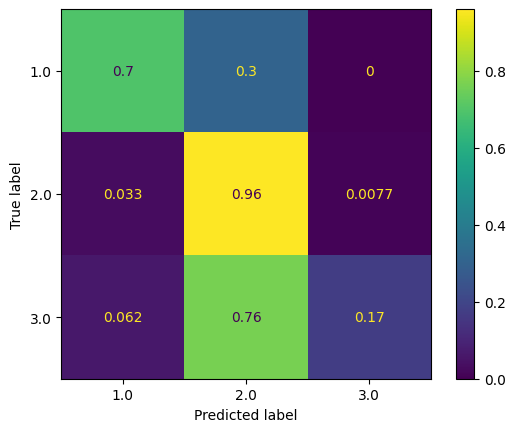

In [62]:
clf = KerasClassifier(
    model=build_mlp,
    epochs=50,
    batch_size=32,
    verbose=0
)

mlp_cv = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler()),
    ("pca", PCA(n_components=12)),
    ("clf", clf)
])

train_mlp(mlp_cv, X_train_lidar, X_test_lidar, y_train_lidar, y_test_lidar)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   7.9s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   7.9s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  12.2s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   9.0s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  10.0s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  10.5s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  10.7s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   8.7s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   9.5s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   9.3s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=32, clf__epochs=100, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  17.4s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=32, clf__epochs=100, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  17.5s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=32, clf__epochs=100, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  16.6s
[CV] END clf__batch_size=32, clf__epochs=100, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  17.3s
[CV] END clf__batch_size=32, clf__epochs=100, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  23.2s
[CV] END clf__batch_size=32, clf__epochs=100, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  46.1s
[CV] END clf__batch_size=32, clf__epochs=100, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  14.7s
[CV] END clf__batch_size=32, clf__epochs=100, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  18.2s
[CV] END clf__batch_size=32, clf__epochs=100, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  15.1s
[CV] END clf__batch_siz

C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   6.4s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   5.8s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   5.8s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   5.4s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=   9.5s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   8.9s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   8.3s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   7.2s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  10.7s
[CV] END clf__batch_size=64, c

C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  21.1s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  30.6s
[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  18.5s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  16.7s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  11.1s
[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  10.9s
[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  25.1s
[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  10.4s
[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  10.5s
[CV] END clf__batch_size=64, clf__epochs=100, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=   9.5s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best CV BA: 0.582, ± 0.012
train score [0.77966507 0.79952153 0.79258373 0.81068581 0.76515152 0.79489633
 0.78692185 0.80478469] vs. cv test score [0.77607656 0.79043062 0.78660287 0.79968102 0.76172249 0.79106858
 0.7814992  0.79712919]
Best params:
  clf__batch_size: 32
  clf__epochs: 100
  clf__model__hidden_layers: (128, 64, 32)
  clf__model__learning_rate: 0.0001
Mean CV accuracy: 0.786, ± 0.002
Mean CV BA: 0.550, ± 0.005
Mean CV f1: 0.551, ± 0.008
Test set accuracy: 0.588
Classification report
               precision    recall  f1-score   support

         1.0       0.85      0.68      0.76       187
         2.0       0.80      0.96      0.87       517
         3.0       0.71      0.12      0.21        80

    accuracy                           0.81       784
   macro avg       0.79      0.59      0.61       784
weighted avg       0.80      0.81      0.78       784

Balanced accuracy score: 0.5883348503811582


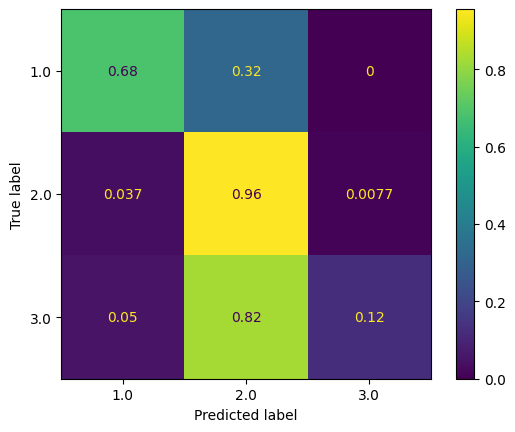

In [16]:
clf = KerasClassifier(
    model=build_mlp,
    epochs=50,
    batch_size=32,
    verbose=0
)

mlp_cv = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler()),
    ("pca", PCA(n_components=0.85)),
    ("clf", clf)
])

train_mlp(mlp_cv, X_train_lidar, X_test_lidar, y_train_lidar, y_test_lidar)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  35.2s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  39.1s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  42.6s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  32.5s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  41.3s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  31.2s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate

C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  20.1s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  23.3s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  26.6s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  23.7s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  22.0s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  28.2s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  25.9s
[CV] END clf__batch_size=64, c

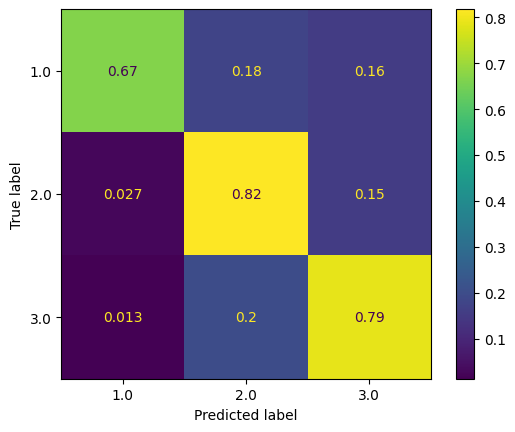

In [76]:
clf = KerasClassifier(
    model=build_mlp,
    epochs=50,
    batch_size=32,
    verbose=0
)

mlp_cv = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler()),
    ("pca", PCA(n_components=12)),
    ("smote", SMOTE(sampling_strategy='minority')),
    ("clf", clf)
])

train_mlp(mlp_cv, X_train_lidar, X_test_lidar, y_train_lidar, y_test_lidar)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  30.3s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  27.5s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  27.6s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  27.4s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  28.6s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  32.9s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate

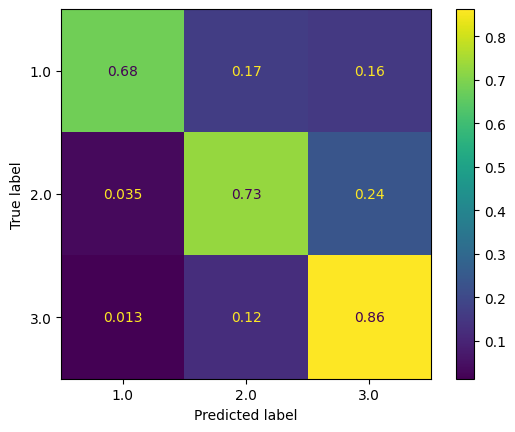

In [77]:
clf = KerasClassifier(
    model=build_mlp,
    epochs=50,
    batch_size=32,
    verbose=0
)

mlp_cv = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler()),
    ("pca", PCA(n_components=12)),
    ("adasyn", ADASYN(sampling_strategy='minority')),
    ("clf", clf)
])

train_mlp(mlp_cv, X_train_lidar, X_test_lidar, y_train_lidar, y_test_lidar)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  26.7s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  27.6s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  30.6s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  35.0s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  42.3s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  34.2s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate

C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  17.4s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  17.5s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  19.5s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  17.3s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  18.3s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  19.1s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  31.5s
[CV] END clf__batch_size=64, c

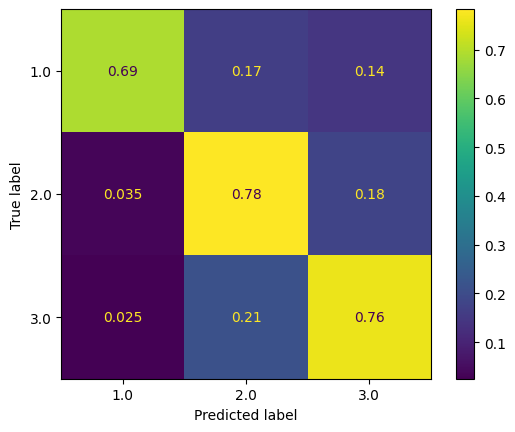

In [78]:
clf = KerasClassifier(
    model=build_mlp,
    epochs=50,
    batch_size=32,
    verbose=0
)

mlp_cv = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler()),
    ("pca", PCA(n_components=12)),
    ("bsmote", BorderlineSMOTE(sampling_strategy='minority')),
    ("clf", clf)
])

train_mlp(mlp_cv, X_train_lidar, X_test_lidar, y_train_lidar, y_test_lidar)

all lidar

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  26.1s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  28.2s


C:\Users\iidam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  31.2s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  47.5s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  34.2s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  29.8s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  33.8s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  33.8s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  31.9s
[CV] END clf__batch_size=32, c

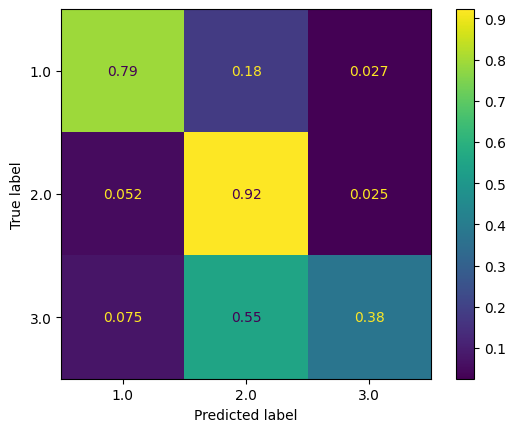

In [20]:
clf = KerasClassifier(
    model=build_mlp,
    epochs=50,
    batch_size=32,
    verbose=0
)

mlp_cv = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler()),
    ("clf", clf)
])

train_mlp(mlp_cv, X_train_lidar, X_test_lidar, y_train_lidar, y_test_lidar)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  25.3s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  23.5s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  22.5s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  26.6s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  29.4s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  31.2s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate

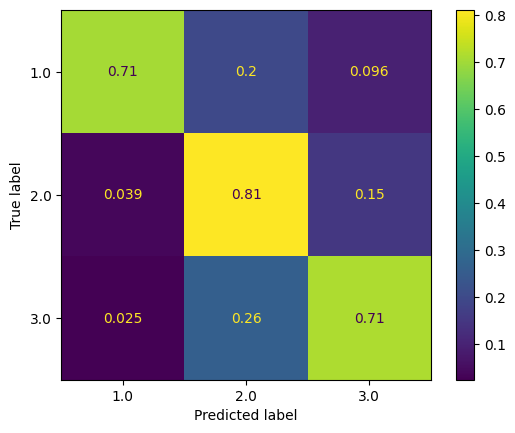

In [21]:
clf = KerasClassifier(
    model=build_mlp,
    epochs=50,
    batch_size=32,
    verbose=0
)

mlp_cv = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler()),
    ("smote", SMOTE(sampling_strategy='minority')),
    ("clf", clf)
])

train_mlp(mlp_cv, X_train_lidar, X_test_lidar, y_train_lidar, y_test_lidar)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  24.3s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  24.2s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  25.1s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  27.2s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  27.7s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  27.0s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate

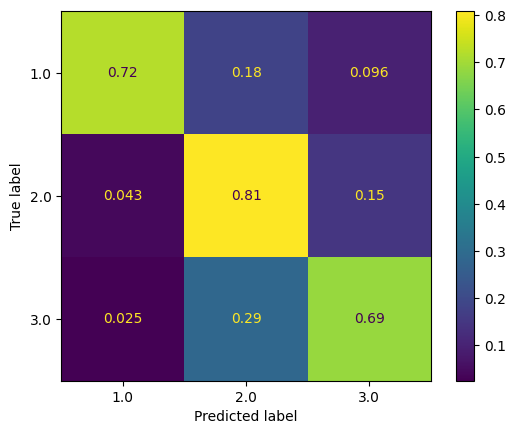

In [22]:
clf = KerasClassifier(
    model=build_mlp,
    epochs=50,
    batch_size=32,
    verbose=0
)

mlp_cv = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler()),
    ("adasyn", ADASYN(sampling_strategy='minority')),
    ("clf", clf)
])

train_mlp(mlp_cv, X_train_lidar, X_test_lidar, y_train_lidar, y_test_lidar)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  26.9s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  27.5s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  29.6s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  28.2s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(64, 32, 16), clf__model__learning_rate=0.0001; total time=  28.7s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate=0.0001; total time=  27.2s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__hidden_layers=(128, 64, 32), clf__model__learning_rate

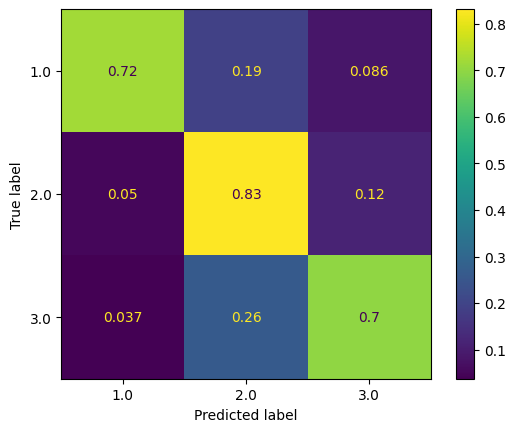

In [23]:
clf = KerasClassifier(
    model=build_mlp,
    epochs=50,
    batch_size=32,
    verbose=0
)

mlp_cv = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler()),
    ("bsmote", BorderlineSMOTE(sampling_strategy='minority')),
    ("clf", clf)
])

train_mlp(mlp_cv, X_train_lidar, X_test_lidar, y_train_lidar, y_test_lidar)